In [1]:
import pandas as pd

In [2]:
headcount = pd.read_excel('../input/Demandv1.1.xlsx',sheet_name='Headcount')
# billable data shows actual demand of past years
headcount = headcount[headcount.Status == 'Billable']

In [3]:
# converting Technologies into one hot encoding
from re import split
cleaned = headcount.set_index('Employee Code').SkillList.str.split(r',\s*(?![^()]*\))', expand=True).stack()
one_hot_coded_df = pd.get_dummies(cleaned).groupby(level=0).sum()
one_hot_coded_df.head()

,(Architecture) - Architecture,(Consulting) - Business Analysis,(D) Capital Markets Sector,(D) Cards,(D) Insurance Sector,(F) Finance / Treasury / Cash / Consolidation,(F) HR,(F) Sales / CRM / Marketing / Offer/ Client Management / Customer Experience,(T) Data / Security / Infastructure Solutions,(T) Data Integration,(T) Data Science and Analytics,(T) Data Visualization,(T) Data and Semantic Modelling,(T) Guidewire,(T) Mainframe Development Technologies,(T) Mobile Development Technologies,(T) Mobile Device Management,(T) Payment solutions,(T) Project Tools,(T) Relational Databases,(T) Testing Tools / Testing Automation / Performance Testing Tools,(T) Web Development Technologies,.Net (WF),.Net (WPF),.Net 1.2,.Net 2.1,".Net 3.0 ( WCF.WPF,WF)",.Net 3.6,.Net Legacy,.Net with MVC,3.x,ADO .NET Entity framework,ADO.NET,ADO.NET3.5,AML,API Integrations- REST,AS/400,ASP.NET,ASP.NET3.1,AWS Redshift,...,VB 6.1,VB Script,VB.NET,VBA,VBA Excel Business Analyst,VBA Macro Excel & .NET,VC++,VISUAL STUDIO,VSAM,Visa H-1B (United States),Vision Plus,VisionPlus (Base I),VisionPlus CMS,VisionPlus FAS,VisionPlus TRAMS,WEBI,WINFORMS,WSS 3.1,Wealth Management,Web Applications,Web Development,WebMethod,WebSphere App Server Admin,Weblogic,Webmethods,Webservices,Websphere Portal Server,Windows,Windows Batch,Windows Commn foundation(WCF),Windows Forms,XML,XSLT1.0,XSLT2.0,e-Learning,iOS,iOS Development,iText,jQuery,ksh (Unix/Linux)
Employee Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10328,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# making index as Employee code for main data frame
head_df = pd.read_excel('../input/Demandv1.1.xlsx',sheet_name='Headcount',index_col='Employee Code')

In [5]:
# merging to daat frame
merged_df = pd.merge(head_df,one_hot_coded_df,left_index=True,right_index=True)

In [6]:
# removing index and unwanted columns
removed_index = merged_df.reset_index(drop=True)

In [7]:
removed_index.columns

Index(['Region', '  Last Name', 'Local Date of Joining', 'Designation',
       'Status', 'Market Unit', 'SkillList', 'Location',
       '(Architecture) - Architecture', '(Consulting) - Business Analysis',
       ...
       'Windows Forms', 'XML', 'XSLT1.0', 'XSLT2.0', 'e-Learning', 'iOS',
       'iOS Development', 'iText', 'jQuery', 'ksh (Unix/Linux)'],
      dtype='object', length=595)

In [8]:
final_df = removed_index.drop(['Region','  Last Name','Status','Market Unit','SkillList'],axis=1).set_index('Local Date of Joining')

In [9]:
final_df.head()

,Designation,Location,(Architecture) - Architecture,(Consulting) - Business Analysis,(D) Capital Markets Sector,(D) Cards,(D) Insurance Sector,(F) Finance / Treasury / Cash / Consolidation,(F) HR,(F) Sales / CRM / Marketing / Offer/ Client Management / Customer Experience,(T) Data / Security / Infastructure Solutions,(T) Data Integration,(T) Data Science and Analytics,(T) Data Visualization,(T) Data and Semantic Modelling,(T) Guidewire,(T) Mainframe Development Technologies,(T) Mobile Development Technologies,(T) Mobile Device Management,(T) Payment solutions,(T) Project Tools,(T) Relational Databases,(T) Testing Tools / Testing Automation / Performance Testing Tools,(T) Web Development Technologies,.Net (WF),.Net (WPF),.Net 1.2,.Net 2.1,".Net 3.0 ( WCF.WPF,WF)",.Net 3.6,.Net Legacy,.Net with MVC,3.x,ADO .NET Entity framework,ADO.NET,ADO.NET3.5,AML,API Integrations- REST,AS/400,ASP.NET,...,VB 6.1,VB Script,VB.NET,VBA,VBA Excel Business Analyst,VBA Macro Excel & .NET,VC++,VISUAL STUDIO,VSAM,Visa H-1B (United States),Vision Plus,VisionPlus (Base I),VisionPlus CMS,VisionPlus FAS,VisionPlus TRAMS,WEBI,WINFORMS,WSS 3.1,Wealth Management,Web Applications,Web Development,WebMethod,WebSphere App Server Admin,Weblogic,Webmethods,Webservices,Websphere Portal Server,Windows,Windows Batch,Windows Commn foundation(WCF),Windows Forms,XML,XSLT1.0,XSLT2.0,e-Learning,iOS,iOS Development,iText,jQuery,ksh (Unix/Linux)
Local Date of Joining,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-08-25,ASSOCIATE CONSULTANT,Noida,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-11-13,CONSULTANT,Noida,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2015-06-15,SENIOR CONSULTANT,Gurgaon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-03-09,MANAGER,Gurgaon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-11-10,SENIOR CONSULTANT,Gurgaon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
final_df['year'] = final_df.index.year
final_df['month']=final_df.index.month
grouped_df = final_df.reset_index(drop=True).groupby(['year','month','Location','Designation']).sum()
grouped_df.head()

,,,,(Architecture) - Architecture,(Consulting) - Business Analysis,(D) Capital Markets Sector,(D) Cards,(D) Insurance Sector,(F) Finance / Treasury / Cash / Consolidation,(F) HR,(F) Sales / CRM / Marketing / Offer/ Client Management / Customer Experience,(T) Data / Security / Infastructure Solutions,(T) Data Integration,(T) Data Science and Analytics,(T) Data Visualization,(T) Data and Semantic Modelling,(T) Guidewire,(T) Mainframe Development Technologies,(T) Mobile Development Technologies,(T) Mobile Device Management,(T) Payment solutions,(T) Project Tools,(T) Relational Databases,(T) Testing Tools / Testing Automation / Performance Testing Tools,(T) Web Development Technologies,.Net (WF),.Net (WPF),.Net 1.2,.Net 2.1,".Net 3.0 ( WCF.WPF,WF)",.Net 3.6,.Net Legacy,.Net with MVC,3.x,ADO .NET Entity framework,ADO.NET,ADO.NET3.5,AML,API Integrations- REST,AS/400,ASP.NET,ASP.NET3.1,AWS Redshift,...,VB 6.1,VB Script,VB.NET,VBA,VBA Excel Business Analyst,VBA Macro Excel & .NET,VC++,VISUAL STUDIO,VSAM,Visa H-1B (United States),Vision Plus,VisionPlus (Base I),VisionPlus CMS,VisionPlus FAS,VisionPlus TRAMS,WEBI,WINFORMS,WSS 3.1,Wealth Management,Web Applications,Web Development,WebMethod,WebSphere App Server Admin,Weblogic,Webmethods,Webservices,Websphere Portal Server,Windows,Windows Batch,Windows Commn foundation(WCF),Windows Forms,XML,XSLT1.0,XSLT2.0,e-Learning,iOS,iOS Development,iText,jQuery,ksh (Unix/Linux)
year,month,Location,Designation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,11,Hartford,SENIOR DIRECTOR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1986,7,Bhubaneswar,CONSULTANT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1987,5,Bhubaneswar,SENIOR DIRECTOR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989,10,Noida,VICE PRESIDENT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1991,3,Noida,CONSULTANT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
def predict_loc_tech(location,technology,desgination,changepoint_prior):
    if location is None and desgination is None:
        location_df = grouped_df
    elif location is None and desgination:
        location_df = grouped_df[(grouped_df.index.get_level_values('Designation') == desgination)]
    elif desgination is None and location:
        location_df = grouped_df[(grouped_df.index.get_level_values('Location') == location)]
    elif location and desgination:
        location_df = grouped_df[(grouped_df.index.get_level_values('Location') == location) & (grouped_df.index.get_level_values('Designation') == desgination)]
    location_df['day'] = 1
    location_df = location_df.reset_index()
    location_df = location_df[location_df.year >= 2010]
    location_df['Date']=pd.to_datetime(location_df[['year','month','day']])
    loc_tech_df = location_df.set_index('Date').resample('M').sum()[[technology]]
    return loc_tech_df

In [12]:
pune_java_df = predict_loc_tech('Pune','Java',None,10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
pune_java_df['Java'] = pune_java_df['Java'].astype('int')

In [14]:
pune_java_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2010-01-31 to 2018-04-30
Freq: M
Data columns (total 1 columns):
Java    100 non-null int64
dtypes: int64(1)
memory usage: 1.6 KB


In [15]:
pune_java_df.head()

,Java
Date,
2010-01-31,1
2010-02-28,0
2010-03-31,2
2010-04-30,0
2010-05-31,2


In [16]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller
# to verify series is random walk or not 
results = adfuller(pune_java_df['Java'])

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
# to check p value
# as p value is 1 we can not reject null hypothesis that it is random walk
results[1]

0.08809424194233145

In [18]:
import numpy as np
log_pune_java_df = pune_java_df.copy()
log_pune_java_df['Java'] = log_pune_java_df['Java'].apply(np.log1p)
results = adfuller(log_pune_java_df['Java'])
results[1]
# p-value is less then 5% so we can  reject null hypothesis that demand of java performs random walk

0.07110491192760704

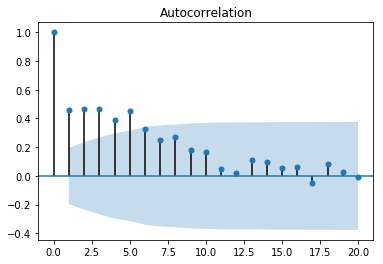

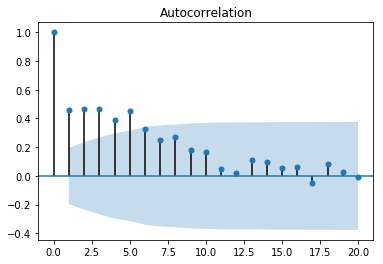

In [19]:
# to plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pune_java_df, lags=20)

In [20]:
diff_pune_java_df = pune_java_df.diff(2).dropna()

In [21]:
results = adfuller(diff_pune_java_df['Java'])
results[1]

0.004263015468448261

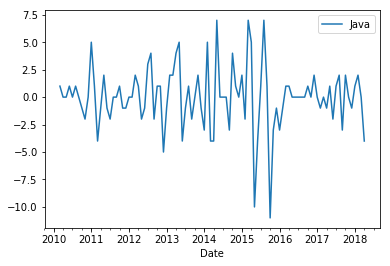

In [22]:
diff_pune_java_df.plot()

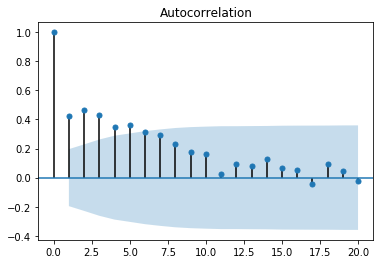

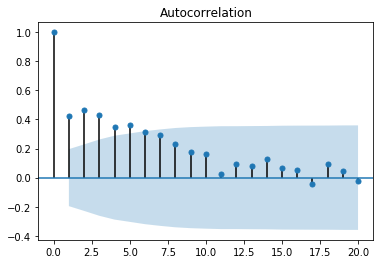

In [23]:
plot_acf(log_pune_java_df, lags=20)

In [24]:
dff_log_df = pune_java_df.apply(np.log1p).diff().dropna()

In [25]:
dff_log_df.head()

,Java
Date,
2010-02-28,-0.693147
2010-03-31,1.098612
2010-04-30,-1.098612
2010-05-31,1.098612
2010-06-30,-0.405465


In [26]:
results = adfuller(dff_log_df['Java'])
results[1]

2.20800534946408e-21

In [27]:
dff_log_df.head()

,Java
Date,
2010-02-28,-0.693147
2010-03-31,1.098612
2010-04-30,-1.098612
2010-05-31,1.098612
2010-06-30,-0.405465


In [28]:
dff_log_df = dff_log_df.reset_index().rename(columns={'Date':'ds','Java':'y'})

In [30]:
# from fbprophet import Prophet
# model = Prophet(changepoint_prior_scale=12,yearly_seasonality=10) #instantiate Prophet
# model.fit(diff_pune_java_df.loc[:87]); #fit the model with your dataframe
# future = model.make_future_dataframe(periods=12,freq='M')
# forecast = model.predict(future)
# print('RMSE: %f' % np.sqrt(np.mean(((np.round(np.exp(forecast['yhat'].loc[87:])-1))-(np.exp(diff_pune_java_df['y'].loc[87:])-1))**2)))


In [31]:
# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode()
# import warnings
# warnings.filterwarnings("ignore")
# py.iplot([
#         go.Scatter(x=dff_log_df['ds'], y=dff_log_df['y'], name='Actual'),
#         go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted'),
#         go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
#         go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
#         go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
#     ])